<b> Note that: </b> If you're using Jupyter Notebook, you won't be needing drive.mount("/content/drive")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing, importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download("all")
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
!pip install compound-word-splitter
!apt install -qq enchant
!pip install pyenchant

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

# Reading in Data & Performing simple preprocessing 

**Data used here:** data.xlsx <br>
<b> Note that: </b> Read from the appropriate directory (Depending on where you saved data.xlsx.)

In [ ]:
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/IS424 Depression Project/data.xlsx")
data.head()

,Unnamed: 0,text,depression
0,0,I recently went through a breakup and she said...,1
1,1,"I do not know how to navigate these feelings, ...",1
2,2,"So I have been with my bf for 5 months , and h...",1
3,3,I am so exhausted of this. Just when I think I...,1
4,4,I have been severly bullied since i was 5 till...,1


In [ ]:
# Dropping Unnamed: 0
data.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
# Converting it to string type because the returned astype of 'text' column is 'float'
data['text'] = data['text'].astype("str")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38362 entries, 0 to 38361
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        38362 non-null  object
 1   depression  38362 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 599.5+ KB


In [ ]:
# Fundamentals
print(f"Shape: ", data.shape)

Shape:  (38362, 2)


In [ ]:
# Checking any missing values
data.isnull().sum()

text          0
depression    0
dtype: int64

# Performing EDA
Q: What kind of words are there in the text column?


Analysis:
- We found out that there are irrelvant stop words everywhere, and therefore, we will performing stop-words removal in a later stage.

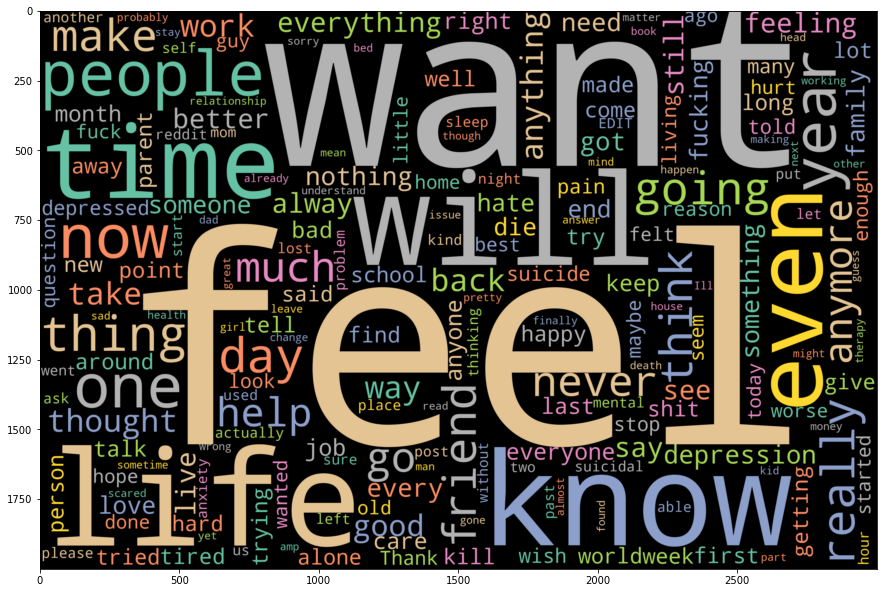

In [ ]:
def listToString(s): 
    str1 = "" 
    for ele in s:
        str1 += ele+" " 
    return str1 

from wordcloud import WordCloud, STOPWORDS
text = listToString(data['text'])

# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(text)

# Plot
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')

# Finding out there are website links

Since this is from reddit, we suspect there were website texts such as http//www.google.com, or www.google.com, therefore, we did a check and found there are almost 1.3K rows that contain these hyperlinks.

In [ ]:
filt = data['text'].str.contains("http") | data['text'].str.contains("www")
data[filt]

,text,depression
20363,I decided to post this partially because I'm i...,0
20365,###Here is a compilation of the top 80 real li...,0
20368,I like the one about the Rugrats. \n\nEver won...,0
20369,For clarification: http://www.eurodezigns.com/...,0
20374,If you have no idea what I'm talking about: [O...,0
...,...,...
35852,Meeeooooaaaaahhhhhrrrrwwww-BOOP,0
36685,**Please reply to my comments with your nomina...,0
37115,Directions:\n\nopen two tabs\n\nin the first t...,0
37173,"**When:** Saturday, April 20 \n\n**Wut:** Sinc...",0


# Check for class imbalance
Let's check if we have a label imbalance problem, and it seems like it's okay.

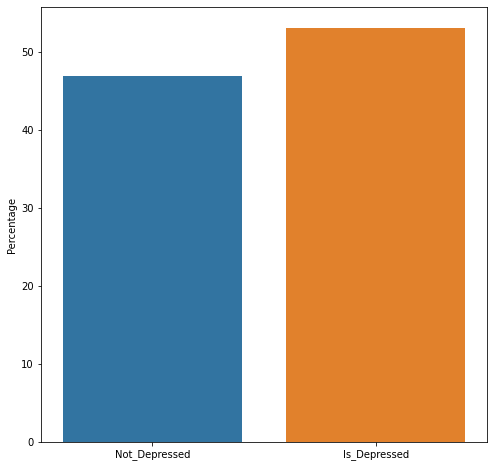

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = data.depression.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Not_Depressed', 'Is_Depressed'])
ax.set_ylabel("Percentage")

plt.show()

# Helper functions needed for preprocessing

In [ ]:
import re 
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "i'd": "i would", "i'd've": "i would have","i'll": "i will",
                     "i'll've": "i will have","i'm": "i am","i've": "i have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return(text)

def clean_text(text):
  """
  Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers
  """
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = re.sub('[‘’“”…]', '', text)
  text = re.sub('\n', '', text)
  text = re.sub("[^a-zA-Z]"," ", text)
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

  return text

def remove_stopwords(paragraph):
  words = nltk.word_tokenize(paragraph)
  wordlist_wo_stopwords=[]
  for w in words:
    if w not in stopWords:
        wordlist_wo_stopwords.append(w)
  # print(wordlist_wo_stopwords)

  return wordlist_wo_stopwords

def get_frequent_words(data):
  lst=[]
  for text in data.values:
      lst+=text[0]
  fdist = FreqDist(lst)
  return fdist.most_common(10)

def remove_freq_words(text):
    result=[]
    for item in text:
        if item not in lst:
            result.append(item)
    
    return result

# Converting arrays to string, works something like a .join()
def listToString(s): 
    str1 = "" 
    for ele in s:
        str1 += ele+" " 
    return str1 

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def lemmatized_with_pos(paragraph):
  words = nltk.word_tokenize(paragraph)
  tagged_words = nltk.pos_tag(words)

  lemmatized_wordlist=[]
  lemmatized_col = []
  for w in tagged_words:
      wordnettag = get_wordnet_pos(w[1])
      if wordnettag == '':
          lemmatizedword = wordnet_lemmatizer.lemmatize(w[0].lower())
      else:
          lemmatizedword = wordnet_lemmatizer.lemmatize(w[0].lower(),pos=wordnettag)
      if w[0].istitle():
          lemmatizedword = lemmatizedword.capitalize()
      elif w[0].upper()==w[0]:
          lemmatizedword = lemmatizedword.upper()
      else:
          lemmatizedword = lemmatizedword

      lemmatized_wordlist.append((w[0],lemmatizedword))

  for lem_word in lemmatized_wordlist:
    lemmatized_col.append(lem_word[1])

  return " ".join(lemmatized_col)
  

# Running through the functions to clean

In [ ]:
# Estimated time 5 mins
wordnet_lemmatizer = WordNetLemmatizer()

stopWords = set(stopwords.words('english'))

df = data.copy()
df['text'] = df['text'].apply(lambda x:expand_contractions(x))
df['text'] = df['text'].apply(lambda x:remove_urls(x))
df['text'] = df['text'].apply(lemmatized_with_pos)
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(remove_stopwords)

freq_words = get_frequent_words(df)
lst = []
for a,b in freq_words:
    lst.append(a)

df['text'] = df['text'].apply(remove_freq_words)
df['text'] = df['text'].apply(listToString)

df.head()

,text,depression
0,recently breakup say still friend say try talk...,1
1,navigate feeling new feeling stretch understan...,1
2,bf month already tell depress week nothing par...,1
3,exhausted finally rest maybe thing start settl...,1
4,severly bully since till result depress misant...,1


# Conducting EDA after Pre-processing:
- Distribution of word count
- Distribution of text lengths
- Top 25 words (After stop word removal)
- Long and Short words


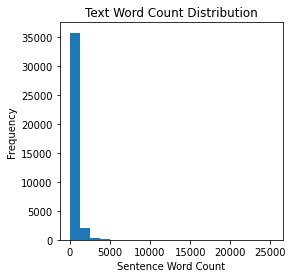

In [ ]:
# As we can see the sentences length are very skewed (even after fundamental preprocessing.)

df['text_count'] = df['text'].str.split(" ").astype(str).apply(len) 

import matplotlib.pyplot as plt 
plt.figure(figsize=(4,4))
plt.hist(df['text_count'], bins=20)
plt.title("Text Word Count Distribution")
plt.style.use('ggplot')
plt.xlabel("Sentence Word Count")
plt.ylabel("Frequency")
plt.show()

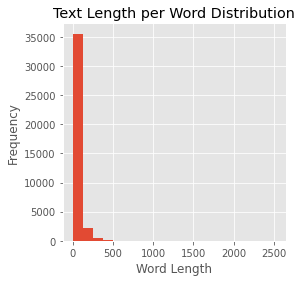

In [ ]:
# Collection of list of vocabs in the dataframe
df['text_tokenized'] = df['text'].str.split(" ")
word_length_list = [len(word) for word in df['text_tokenized']]

import matplotlib.pyplot as plt 
plt.figure(figsize=(4,4))
plt.hist(word_length_list, bins=20)
plt.title("Text Length per Word Distribution")
plt.style.use('ggplot')
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


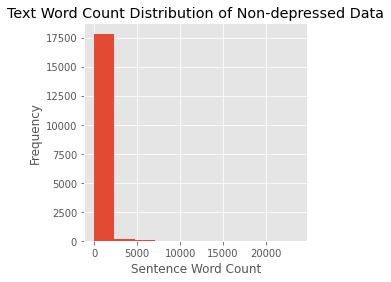

In [ ]:
#Non-depressed word distribution
nondepressed_df = df[df['depression'] == 0]
nondepressed_df['text_count'] = nondepressed_df['text'].str.split(" ").astype(str).apply(len) 
import matplotlib.pyplot as plt 
plt.figure(figsize=(4,4))
plt.hist(nondepressed_df['text_count'], bins=10)
plt.title("Text Word Count Distribution of Non-depressed Data")
plt.style.use('ggplot')
plt.xlabel("Sentence Word Count")
plt.ylabel("Frequency")
plt.show()

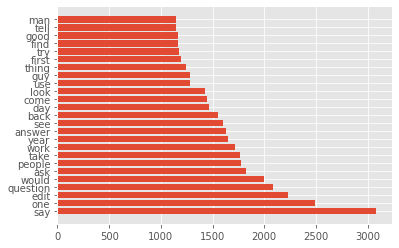

In [ ]:
#Most popular words in Non-depressed
from collections import Counter
nondepressed_freq = Counter(" ".join(nondepressed_df['text']).split()).most_common(25)
rslt = pd.DataFrame(nondepressed_freq, columns=['Word', 'Frequency'])
plt.barh(rslt['Word'],rslt['Frequency'])
plt.show()

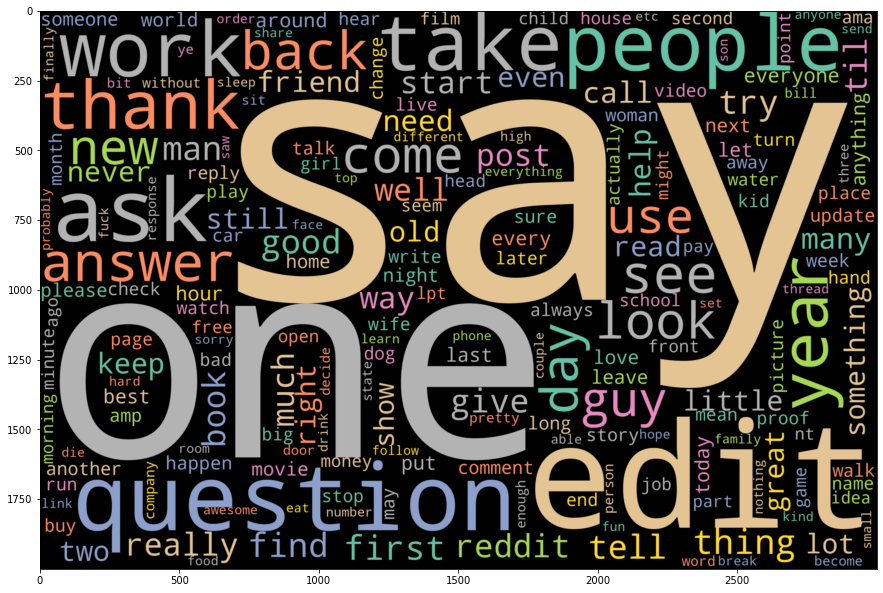

In [ ]:
#Most popular words in Non-depressed
nondepressed_text = listToString(nondepressed_df['text'])

# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(nondepressed_text)

# Plot
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


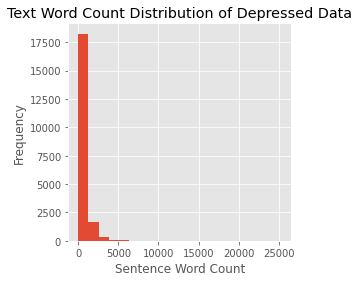

In [ ]:
#depressed word distribution
depressed_df = df[df['depression'] == 1]
depressed_df['text_count'] = depressed_df['text'].str.split(" ").astype(str).apply(len) 
import matplotlib.pyplot as plt 
plt.figure(figsize=(4,4))
plt.hist(depressed_df['text_count'], bins=20)
plt.title("Text Word Count Distribution of Depressed Data")
plt.style.use('ggplot')
plt.xlabel("Sentence Word Count")
plt.ylabel("Frequency")
plt.show()

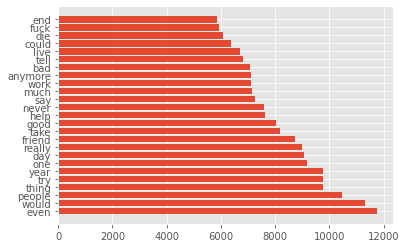

In [ ]:
#Most popular words in Depressed
from collections import Counter
depressed_freq = Counter(" ".join(depressed_df['text']).split()).most_common(25)
rslt = pd.DataFrame(depressed_freq, columns=['Word', 'Frequency'])
plt.barh(rslt['Word'],rslt['Frequency'])
plt.show()

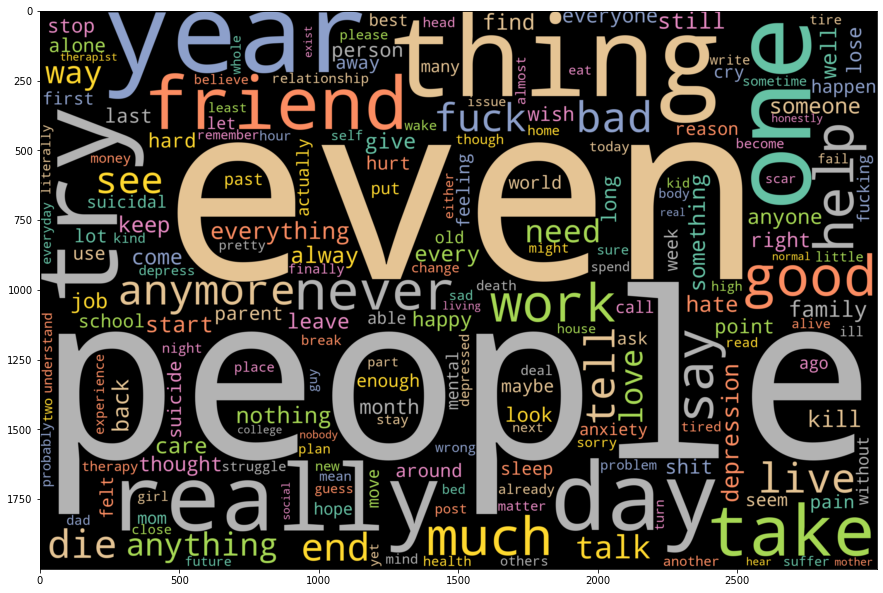

In [ ]:
#Most popular words in Depressed
depressed_text = listToString(depressed_df['text'])

# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(depressed_text)

# Plot
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')

In [ ]:
df = df.drop(['text_tokenized', 'text_count'], axis=1)

# Extracting Useful Words

Finding out the long and short words with an arbitary length of 15. Basically we want to find out what are these words that are so long, or words that are so short that might not be essential for our project.

In [ ]:
# Finding out what is wrong with the long and short words
train = df.copy().reset_index()
limit_count = 15
big_words = []
small_words = []

train['text'] = train['text'].apply(lambda x: x.split(" "))
for idx in range(len(train)):
  row = train.loc[idx]['text']

  for word in row:
    if len(word) > limit_count and word not in big_words:
      big_words.append(word)

    if len(word) < 3 and word not in small_words:
      small_words.append(word)

print((small_words))
print(big_words)

['', 'bf', 'e', 'ex', 'pt', 'id', 'u', 'ok', 'di', 'nt', 'gf', 'ik', 'ur', 'af', 'oh', 'n', 'er', 'il', 'dy', 'bp', 'nh', 'bc', 'tw', 'ed', 'bs', 'po', 'x', 'b', 'rn', 'um', 'yr', 'eg', 'fb', 'ta', 'tv', 'gp', 'gc', 'xd', 'k', 'jb', 'mh', 'uk', 'j', 'lt', 'yo', 'ba', 'ge', 'mg', 'ha', 'st', 'rc', 'de', 'se', 'ai', 'eu', 'na', 'ja', 'os', 'ao', 'la', 'da', 'ou', 'lb', 'wa', 'iq', 'hi', 'gt', 'le', 'ah', 'f', 'od', 'sh', 'ig', 'eh', 'pc', 'w', 'mr', 'ie', 'iv', 'h', 'dr', 'ii', 'ac', 'r', 'fr', 'tf', 'wv', 'fo', 'p', 'pm', 'gd', 'z', 'vs', 'tl', 'uo', 'ir', 'tt', 'co', 'jr', 'cn', 'si', 'ti', 'uh', 'ya', 'c', 'un', 'tm', 'tu', 'ot', 'v', 'l', 'el', 'lk', 'nd', 'ab', 'hd', 'mf', 'ad', 'mv', 'vr', 'sa', 'wd', 'th', 'jm', 'hr', 'yt', 'ty', 'mw', 'mo', 'q', 'cu', 'dx', 'ci', 'hm', 'km', 'md', 'dw', 'sm', 'dk', 'g', 'ps', 'hw', 'cw', 'pe', 'az', 'al', 'dm', 'gg', 'ho', 'ne', 'cv', 'aa', 'fk', 'sp', 'rl', 'bi', 'ny', 'sf', 'du', 'gi', 'rm', 'ri', 'ca', 'dj', 'us', 'pi', 'yk', 'bk', 'mn', 'en',

# Small and Big Words Wordcloud

**Upon displaying them in a wordcloud we identified two things:** <br>
1) small_words consist of redundant words and it would be computationally wasteful to just add on into the training algorithm later, thus we will just remove them out of the data (per sentence) <br>
2) big_words consist of words that are joined together, e.g. anxietydepression, thus, we need to find a way to split them to make each word more meaningful.

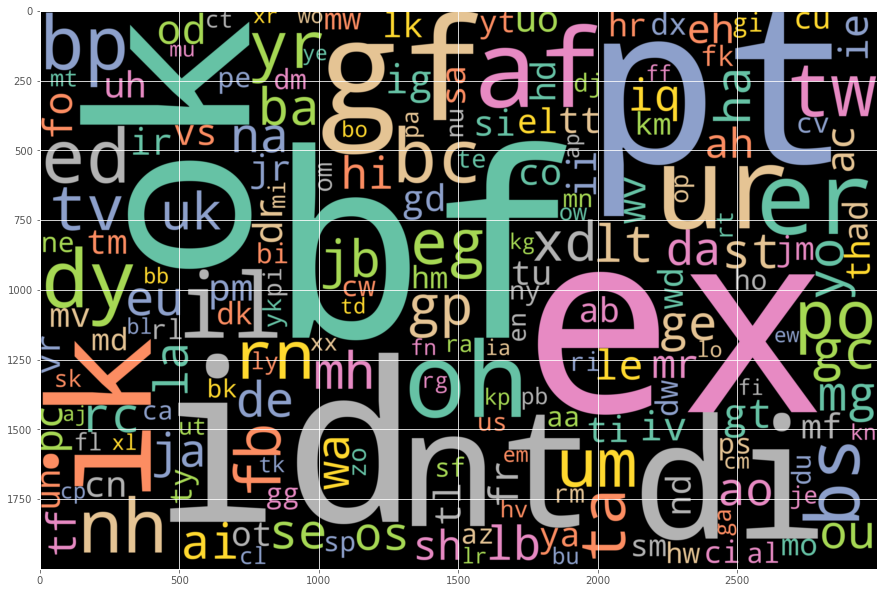

In [ ]:
# Displaying them in a word cloud (Small Words)
text = listToString(small_words)

# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(text)

# Plot
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')

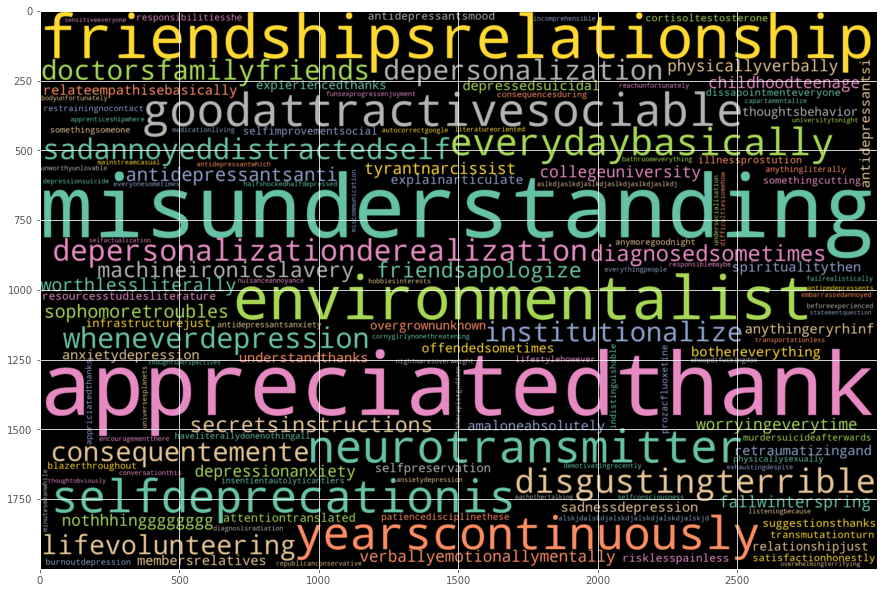

In [ ]:
# Displaying them in a word cloud (Big Words)
text = listToString(big_words)

# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(text)

# Plot
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')

The step below is to reduce computational time when we are removing the super long words. Using a word cloud, you'll realise all these words are pretty much redundant. (46 is a number we arrived upon taking some time to examine the whole dataset manually.)

['aaaaaaaaaaaaaaaaaaaaaaandjxjsjjxjjcskkekckkcksk', 'soigottogoaboutitthiswayhumiliatingtorturingway', 'iowainternetuncaucusisnotyourgrandfatherscaucus', 'stillherebackonlineafterayearwithouttheinternet', 'tipclearyourbrowserscookiesbeforebookingflights', 'loansforgivenesscancellationchartspublicservice', 'businessmenrichestbillionairesbillgatesnetworth', 'congressionalcandidatetakesontheocraticincumbent', 'keywordsthelegendofkorraoriginalmusicfrombookone', 'tnomountainhighenoughisouttomorrowpickupyourcopy', 'groupprogramsandvisitslegocertifiedprofessionals', 'dictionarybygoogmgijmajocgfcbeboacabfgobmjgjcoja', 'cmsagencyinformationcmsleadershipofficefchcohtml', 'quantummeasurementsleaveschrodingerscatalivehtml', 'eikjwwefgbhjbgdesahgjbsgyhbjaswedgvhbzdsghbvashbvg', 'nyjfdjddjjwjwjwjwjajajakakkalalakakajsnenenennendnd', 'amygoodmanofdemocracynowinterviewvoicesfromlaosteam', 'billfaqdisturbingprivacydangerscispaandhowyoustopit', 'arborcompublicoutreachfindatreecareserviceindexaspx', 'tob

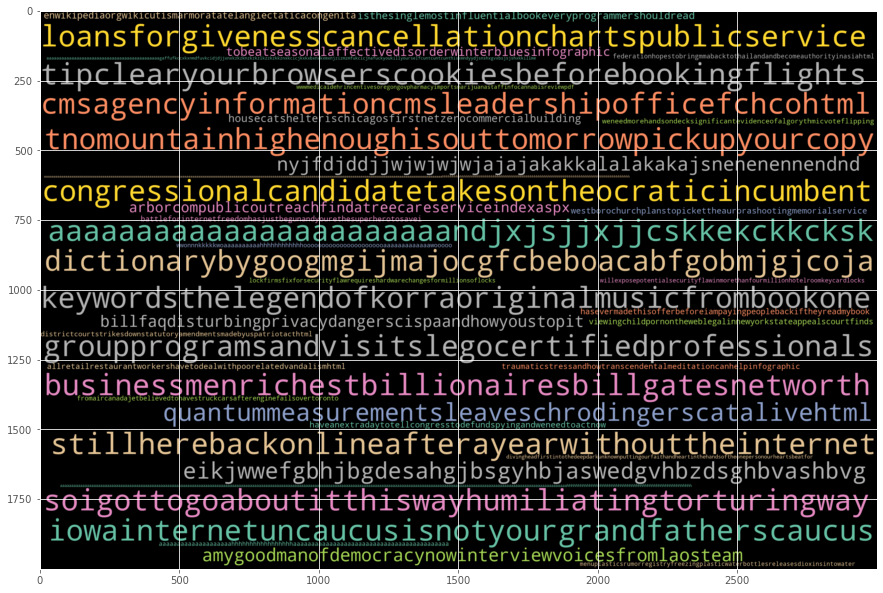

In [ ]:
#  Finding out what are the big words that are above > 46
sorted_big_words = sorted(big_words, key=len)

# Creating the word-to-length dict
word_to_length = dict()
for word in sorted_big_words:
  word_to_length[word] = len(word) 

long_words = []
for word, value in word_to_length.items():
  if value > 46:
    long_words.append(word)

# These are the words that are causing the removal program to be really slow
print(long_words)

# Displaying them in a word cloud (long Words)
text = listToString(long_words)

# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(text)

# Plot
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')

In [ ]:
"""
  1) Find out from the dictionary word_to_length what are the words that have insane lengths
  2) Find out the rows that contain these words (high chance that they're unique)
  3) If row is insiginificant, drop the row. And since we found that most words > 46 are pretty much useless, we will just remove them.
  4) Re-run removal methods.
"""

def remove_redundant_long_words(paragraph):
  text_cleaned = []
  tokens = paragraph.split(" ")
  for idx, word in enumerate(tokens):
    if len(word) <= 46:
      text_cleaned.append(word)

  return " ".join(text_cleaned)

df['text'] = df['text'].apply(remove_redundant_long_words)

# Retrieve words from very long words
At this point, we will only have 'useful' big words, so let's try to make some meaning out of these concatenated words. At the same the same time, removing useless small words (words with length less than (<) 3)

In [ ]:
# So the goal now is to split those 'joined' words with a library, and see if we can do further removal of useless words.
import splitter

def bigwords_advanced_cleaning(paragraph):

  result = []
    
  tokens = paragraph.split(" ")
  for outer_idx, word in enumerate(tokens):
    if len(word) > 15:
      # ['r', 'take'...]
      split_words = splitter.split(word)

      # The result for a nonsencial string is '' for e.g. 'aaaaaa'
      if split_words == '':
        continue

      # cases like Gastroenterology (Corner cases)
      if type(split_words) != list:
        result.append(split_words.lower())
        continue 
        
      for idx, split_word in enumerate(split_words):
        # remove super small split_word

        if (len(split_word) < 3 or split_word == ''):
          split_words.pop(idx)  
      
      for split_word in split_words:
        result.append(split_word)

    else:
      result.append(word)

  return " ".join(result)

def small_words_removal(paragraph):
  result = []
  tokens = paragraph.split(" ")
  for word in tokens:
    if len(word) >= 3:
      result.append(word)
  
  return " ".join(result)


In [ ]:
df['text'] = df['text'].apply(small_words_removal)
df['text'] = df['text'].apply(bigwords_advanced_cleaning)

# Apply again because there will be some residual small_words after seperating small_words.
df['text'] = df['text'].apply(small_words_removal)

df.head()

,text,depression
0,recently breakup say still friend say try talk...,1
1,navigate feeling new feeling stretch understan...,1
2,month already tell depress week nothing partic...,1
3,exhausted finally rest maybe thing start settl...,1
4,severly bully since till result depress misant...,1



Let's check again, if we have successfully found the good words that were concatenated in the big_words.

In [ ]:
train = df.copy().reset_index()
limit_count = 15
big_words = []
small_words = []

train['text'] = train['text'].apply(lambda x: x.split(" "))
for idx in range(len(train)):
  row = train.loc[idx]['text']

  for word in row:
    if len(word) > limit_count and word not in big_words:
      big_words.append(word)

    if len(word) < 3 and word not in small_words:
      small_words.append(word)

print("Small words' length now:", len(small_words))

Small words' length now: 1


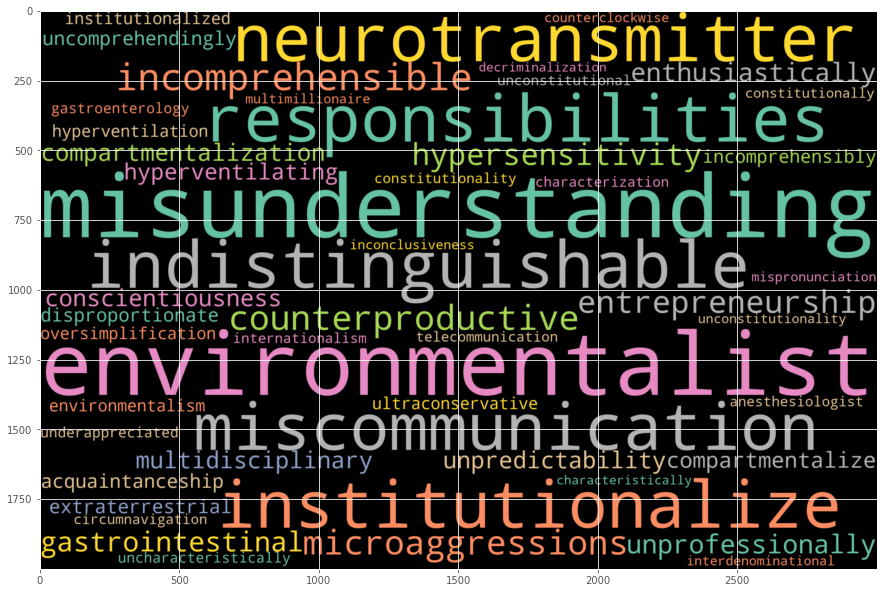

In [ ]:
# Displaying them in a word cloud (long Words)
text = listToString(big_words)

# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(text)

# Plot
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')

Wow! The words above now are so useful :) At this point, I exported the data out into another excel file called model_data_v2.xlsx in order to prevent any accidental re-runs.

In [ ]:
df.to_excel("/content/drive/MyDrive/Colab Notebooks/IS424 Depression Project/model_data_v2.xlsx")